In [1]:
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import gridspec
%matplotlib inline
from sklearn.gaussian_process.kernels import Matern, RBF
from sklearn.gaussian_process import GaussianProcessRegressor
from bayes_opt import BayesianOptimization
from bayes_opt import UtilityFunction
#import plotly.express as px
import os

In [4]:
plt.rcParams['figure.figsize'] = [15, 5]

In [5]:
def posterior(optimizer, x_obs, y_obs, grid):
    optimizer._gp.fit(x_obs, y_obs)

    mu, sigma = optimizer._gp.predict(grid, return_std=True)
    return mu, sigma

def plot_gp(optimizer, x, y, pbounds = {'x' : (-5, 5)}, acq_='ucb', xi_=0, kappa_=5, output_folder = None):
    fig = plt.figure(figsize=(16, 10))
    steps = len(optimizer.space)
    fig.suptitle(
        'Gaussian Process and Acquisition Function After {} Steps'.format(steps), size = 20)
    
    gs = gridspec.GridSpec(2, 1, height_ratios=[3, 1]) 
    axis = plt.subplot(gs[0])
    acq = plt.subplot(gs[1])
    
    x_obs = np.array([[res["params"]["x"]] for res in optimizer.res])
    y_obs = np.array([res["target"] for res in optimizer.res])
    
    mu, sigma = posterior(optimizer, x_obs, y_obs, x)
    axis.plot(x, y, ':', linewidth=3, label='Target', color = 'k')
    axis.plot(x, mu, linewidth=2.5, color='k', label='Prediction')
    axis.plot(x_obs.flatten(), y_obs, '.', markersize=24, label=u'Observations', color='#FFC81B')

    axis.fill(np.concatenate([x, x[::-1]]), 
              np.concatenate([mu - 1.9600 * sigma, (mu + 1.9600 * sigma)[::-1]]),
              color = '#FFEB77', alpha=.6, fc='c', ec='None', label='95% confidence interval')
    
    axis.set_xlim((pbounds['x'][0], pbounds['x'][1]))
    axis.set_ylim((None, None))
    axis.set_ylabel('f(x)', fontdict={'size':20})
    axis.set_xlabel('x', fontdict={'size':20})
    
    utility_function = UtilityFunction(kind=acq_, kappa=kappa_, xi=xi_)
    utility = utility_function.utility(x, optimizer._gp, optimizer._space.target.max())
    acq.plot(x, utility, label='Acquisition Function', color='#C2F3AD', lw=2.5)
    acq.fill_between(x.flatten(), utility, color='#DAFFCA')
    
    acq.plot(optimizer.suggest(utility_function)['x'], np.max(utility), '*', markersize=15, 
             label=u'Next Best Guess', markerfacecolor='#FFC81B', markeredgecolor='k', markeredgewidth=0.5)
    acq.set_xlim((pbounds['x'][0], pbounds['x'][1]))
    acq.set_ylim((0, np.max(utility) + 0.2*np.abs(np.max(utility))))
    acq.set_ylabel('Acquisition Function', fontdict={'size':20})
    acq.set_xlabel('x', fontdict={'size':20})
    
    axis.legend(loc=2, bbox_to_anchor=(1.01, 1), borderaxespad=0.)
    acq.legend(loc=2, bbox_to_anchor=(1.01, 1), borderaxespad=0.)
    
    #plt.savefig(fr'sin.png', bbox_inches = 'tight')
    
    if output_folder:
        if not os.path.exists(output_folder):
            os.makedirs(output_folder)

        plt.savefig(fr'{output_folder}\\{steps}.png', bbox_inches = 'tight')

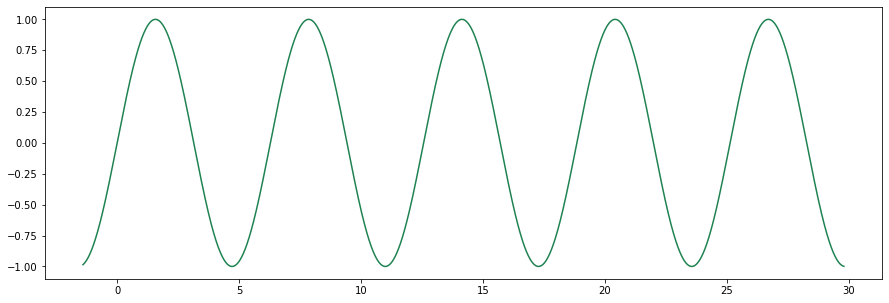

In [6]:
def target(x):
    return np.sin(x)

x = np.linspace(-1.4, 29.8, 10000).reshape(-1, 1)
y = target(x)

plt.plot(x, y, '#1E8251')
plt.show()

In [ ]:
bounds = {'x': (-1.4, 29.8)}
optimizer = BayesianOptimization(target, bounds)

for i in [1, 5, 9, 13, 17]:
    optimizer.probe(
        params=[i*np.pi/2],
        lazy=True)
    
optimizer.maximize(init_points=0, n_iter=0)
plot_gp(optimizer, x, y, bounds)

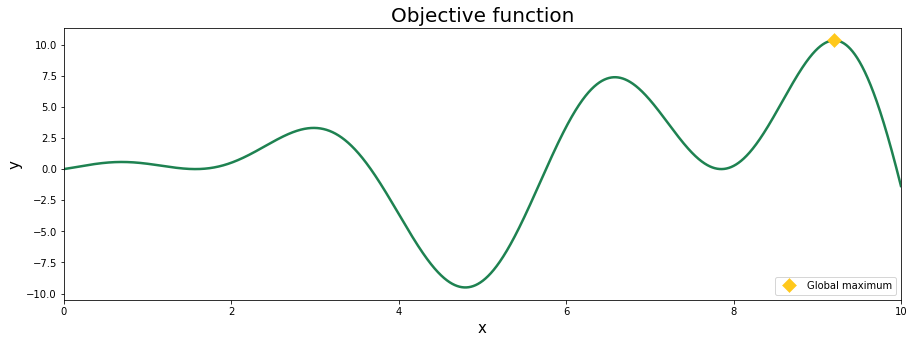

In [7]:
def target(x):
    return x*np.sin(x) + x*np.cos(2*x)

x = np.linspace(0, 10, 10000).reshape(-1, 1)
y = target(x)

plt.plot(x, y, '#1E8251', lw=2.5)
plt.title('Objective function', fontsize = 20)
plt.plot(9.2, 10.34, 'D', markersize=10, markerfacecolor='#FFC81B', markeredgecolor='#FFC81B', 
         markeredgewidth=0.5, label='Global maximum')
plt.xlim(0, 10)
plt.ylabel('y', fontdict={'size':15})
plt.xlabel('x', fontdict={'size':15})

plt.legend(loc='lower right')
plt.savefig(f'target.png', bbox_inches = 'tight')
plt.show()

In [117]:
np.max(y)

10.336796253972276

In [118]:
target(9.2)

10.336476795662147

In [ ]:
bounds = {'x': (0, 10)}
output = 'example'
optimizer = BayesianOptimization(target, bounds, random_state=26111995)
    
optimizer.maximize(init_points=2, n_iter=0, acq='ucb', xi=1, kappa=5)
plot_gp(optimizer, x, y, bounds, acq_='ucb', xi_=1, kappa_=5, output_folder=output)

for i in range(28):
    optimizer.maximize(init_points=0, n_iter=1, acq='ucb', xi=1, kappa=5)
    plot_gp(optimizer, x, y, bounds, acq_='ucb', xi_=1, kappa_=5, output_folder=output)

|   iter    |  target   |     x     |
-------------------------------------
|  1        |  6.146    |  6.265    |
|  2        |  0.0897   |  1.359    |
|  3        |  6.146    |  6.265    |
|  4        |  7.378    |  6.576    |
|  5        |  7.235    |  6.693    |
|  6        |  7.369    |  6.611    |
|  7        |  7.379    |  6.587    |
|  8        |  7.379    |  6.584    |
|  9        |  7.379    |  6.584    |
|  10       |  7.379    |  6.583    |
|  11       | -1.359    |  10.0     |
|  12       |  7.379    |  6.584    |
|  13       |  7.379    |  6.583    |
|  14       |  7.379    |  6.583    |
|  15       |  7.379    |  6.584    |
|  16       |  7.379    |  6.583    |
|  17       |  7.379    |  6.583    |
|  18       |  7.379    |  6.581    |
|  19       |  7.379    |  6.585    |
|  20       | -3.06     |  3.952    |
|  21       |  7.379    |  6.583    |
|  22       |  7.379    |  6.581    |
|  23       |  7.379    |  6.585    |
|  24       |  7.379    |  6.581    |
|  25       

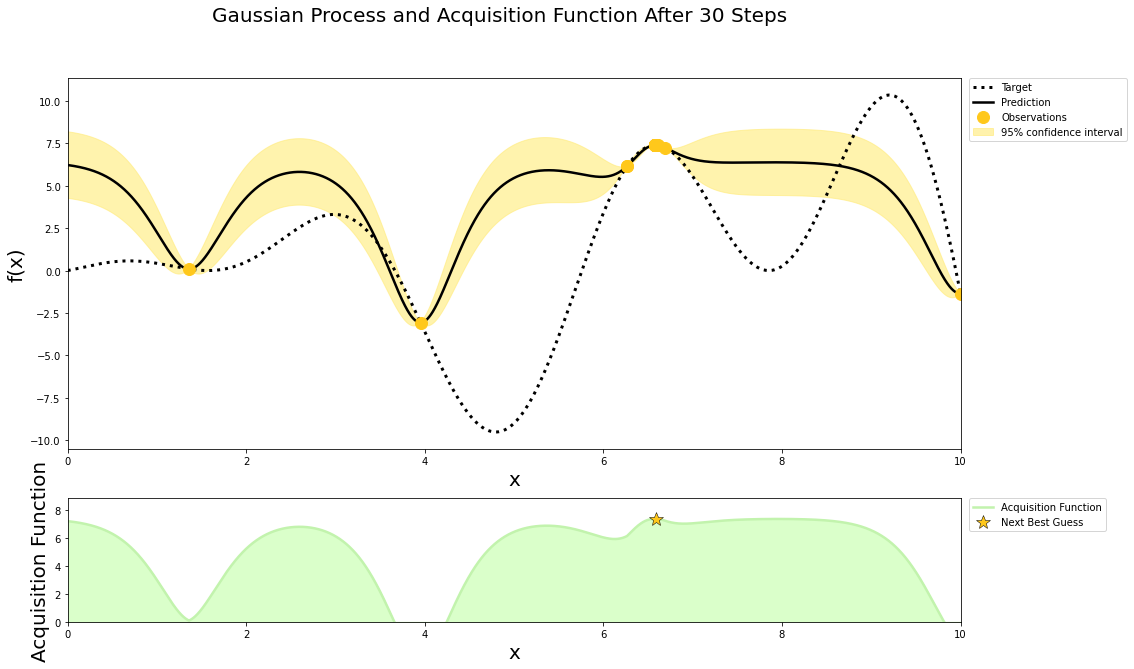

In [193]:
bounds = {'x': (0, 10)}
optimizer = BayesianOptimization(target, bounds, random_state=268855)
    
optimizer.maximize(init_points=2, n_iter=28, acq='ucb', kappa=1)
plot_gp(optimizer, x, y, bounds, acq_='ucb', kappa_=1)

|   iter    |  target   |     x     |
-------------------------------------
|  1        |  1.52     |  3.485    |
|  2        | -0.5586   |  3.722    |
|  3        |  0.001405 |  1.546    |
|  4        |  0.2493   |  1.874    |
|  5        |  5.558    |  8.593    |
|  6        |  5.56     |  8.593    |
|  7        |  9.809    |  9.026    |
|  8        |  8.666    |  9.501    |
|  9        |  6.942    |  6.393    |
|  10       | -2.744    |  5.577    |
|  11       |  5.251    |  7.038    |
|  12       |  5.252    |  7.038    |
|  13       | -1.359    |  10.0     |
|  14       |  0.1107   |  7.756    |
|  15       |  0.0      |  0.0      |
|  16       |  2.993    |  2.748    |
|  17       | -9.155    |  4.623    |
|  18       |  0.5601   |  0.7687   |
|  19       |  7.221    |  6.698    |
|  20       |  10.28    |  9.261    |
|  21       |  1.618    |  2.343    |
|  22       |  4.0      |  6.049    |
|  23       |  1.46     |  8.208    |
|  24       |  3.218    |  3.1      |
|  25       

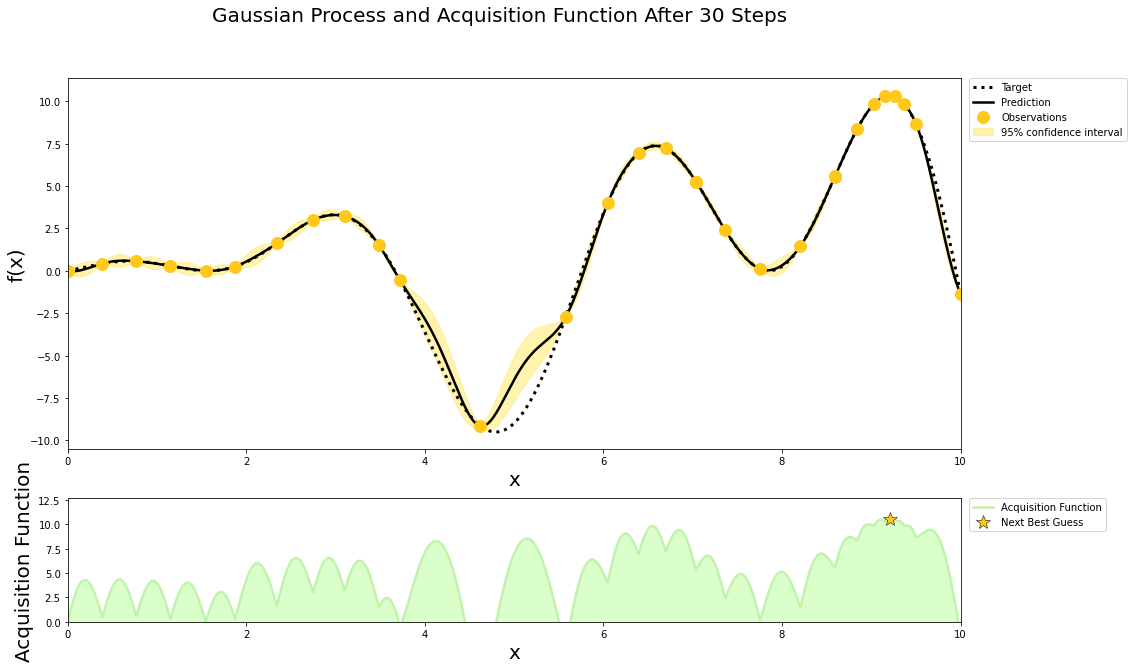

In [202]:
bounds = {'x': (0, 10)}
optimizer = BayesianOptimization(target, bounds, random_state=1995)
    
optimizer.maximize(init_points=2, n_iter=28, acq='ucb', kappa=20)
plot_gp(optimizer, x, y, bounds, acq_='ucb', kappa_=20)